# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

# **IMPORTAR LIBRERÍAS**

In [17]:
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# **DESCARGAR Y TRANSFORMAR HTML**

In [18]:

# Configuración del user-agent y URL
url = "https://ycharts.com/companies/TSLA/revenues"
headers = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36"}
response = requests.get(url, headers=headers)

# Parsear el contenido HTML
if response.status_code == 200:
    soup = BeautifulSoup(response.text, "html.parser")
    
    # Buscar todas las tablas
    table = soup.find("table")  # Suponemos que la tabla principal tiene el tag <table>
    
    if table:
        rows = table.find_all("tr")  # Buscar todas las filas dentro de la tabla
        data = []

        # Extraer datos de las filas
        for row in rows[1:]:  # Saltamos la cabecera
            cols = row.find_all("td")
            if len(cols) == 2:
                date = cols[0].get_text(strip=True)
                revenue = cols[1].get_text(strip=True)
                data.append({"Date": date, "Revenue": revenue})

        # Crear DataFrame
        tesla_revenue = pd.DataFrame(data)
        print(tesla_revenue)
    else:
        print("No se encontró ninguna tabla en el HTML.")
else:
    print("No se pudo acceder a la página web.")


                  Date Revenue
0   September 30, 2024  25.18B
1        June 30, 2024  25.50B
2       March 31, 2024  21.30B
3    December 31, 2023  25.17B
4   September 30, 2023  23.35B
5        June 30, 2023  24.93B
6       March 31, 2023  23.33B
7    December 31, 2022  24.32B
8   September 30, 2022  21.45B
9        June 30, 2022  16.93B
10      March 31, 2022  18.76B
11   December 31, 2021  17.72B
12  September 30, 2021  13.76B
13       June 30, 2021  11.96B
14      March 31, 2021  10.39B
15   December 31, 2020  10.74B
16  September 30, 2020  8.771B
17       June 30, 2020  6.036B
18      March 31, 2020  5.985B
19   December 31, 2019  7.384B
20  September 30, 2019  6.303B
21       June 30, 2019   6.35B
22      March 31, 2019  4.541B
23   December 31, 2018  7.226B
24  September 30, 2018  6.824B


# **LIMPIEZA DE DATOS Y ALMACENAMIENTO EN SQLITE**

In [19]:
# Limpieza de la columna Revenue
def parse_revenue(value):
    if "B" in value:  # Billones
        return float(value.replace("B", "").replace(",", "").strip()) * 1e9
    elif "M" in value:  # Millones
        return float(value.replace("M", "").replace(",", "").strip()) * 1e6
    else:  # Otros casos (valores numéricos simples)
        return float(value.replace(",", "").strip())

# Aplicar la función a la columna Revenue
tesla_revenue["Revenue"] = tesla_revenue["Revenue"].apply(parse_revenue)

# Convertir valores limpios a float
tesla_revenue["Revenue"] = tesla_revenue["Revenue"].astype(float)

# Continuar con SQLite
import sqlite3

# Conectar a SQLite
connection = sqlite3.connect("Tesla.db")
cursor = connection.cursor()

# Crear la tabla (si no existe)
cursor.execute("""
CREATE TABLE IF NOT EXISTS revenue (
    Date TEXT,
    Revenue REAL
)
""")

# Insertar datos en la tabla
tesla_tuples = list(tesla_revenue.to_records(index=False))  # Convierte el DataFrame en una lista de tuplas
cursor.executemany("INSERT INTO revenue (Date, Revenue) VALUES (?, ?)", tesla_tuples)

# Guardar cambios
connection.commit()

# Consultar y mostrar los datos almacenados
for row in cursor.execute("SELECT * FROM revenue"):
    print(row)

# Cerrar conexión
connection.close()


('September 30, 2024', 25180000000.0)
('June 30, 2024', 25500000000.0)
('March 31, 2024', 21300000000.0)
('December 31, 2023', 25170000000.0)
('September 30, 2023', 23350000000.0)
('June 30, 2023', 24930000000.0)
('March 31, 2023', 23330000000.0)
('December 31, 2022', 24320000000.0)
('September 30, 2022', 21450000000.0)
('June 30, 2022', 16930000000.0)
('March 31, 2022', 18760000000.0)
('December 31, 2021', 17720000000.0)
('September 30, 2021', 13760000000.0)
('June 30, 2021', 11960000000.0)
('March 31, 2021', 10390000000.0)
('December 31, 2020', 10740000000.0)
('September 30, 2020', 8771000000.0)
('June 30, 2020', 6036000000.0)
('March 31, 2020', 5985000000.0)
('December 31, 2019', 7384000000.0)
('September 30, 2019', 6303000000.0)
('June 30, 2019', 6350000000.0)
('March 31, 2019', 4541000000.0)
('December 31, 2018', 7226000000.0)
('September 30, 2018', 6824000000.0)
('September 30, 2024', 25180000000.0)
('June 30, 2024', 25500000000.0)
('March 31, 2024', 21300000000.0)
('December 31,

# **VISUALIZACIÓN**


## **VISUALIZACIÓN EN SERIES DE TIEMPO**

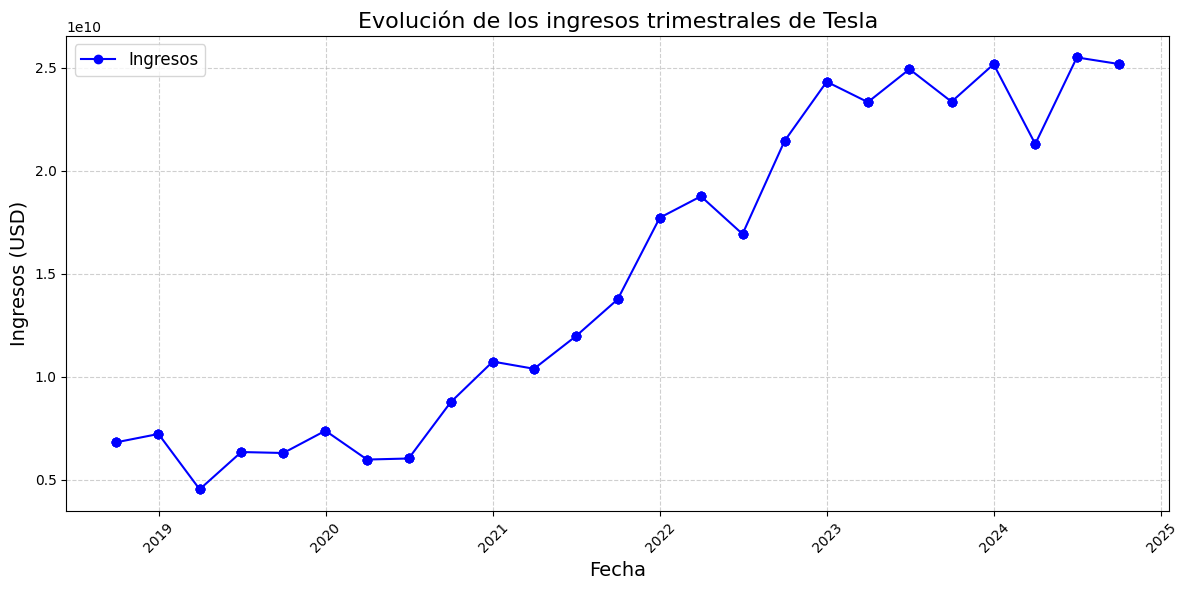

In [20]:

# Conectar a SQLite y cargar los datos en un DataFrame
connection = sqlite3.connect("Tesla.db")
query = "SELECT * FROM revenue"
tesla_revenue = pd.read_sql_query(query, connection)

# Convertir la columna Date a tipo datetime y ordenarla
try:
    tesla_revenue["Date"] = pd.to_datetime(tesla_revenue["Date"], format="%B %d, %Y", errors="coerce")
except Exception as e:
    print(f"Error al convertir las fechas: {e}")

# Eliminar filas con fechas no válidas
tesla_revenue = tesla_revenue.dropna(subset=["Date"])
tesla_revenue = tesla_revenue.sort_values(by="Date")

# Crear el gráfico de series de tiempo
plt.figure(figsize=(12, 6))
plt.plot(tesla_revenue["Date"], tesla_revenue["Revenue"], marker='o', color='blue', label="Ingresos")

# Mejorar la visualización
plt.title("Evolución de los ingresos trimestrales de Tesla", fontsize=16)
plt.xlabel("Fecha", fontsize=14)
plt.ylabel("Ingresos (USD)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# Cerrar la conexión a la base de datos
connection.close()


**EVOLUCIÓN DE LOS INGRESOS TRIMESTRLES DE TESLA DESDE 2019 HASTA 2024: Tendencia alcista con algunas variaciones.**


**Tendencia General:**

- *Crecimiento sostenido:* Desde 2019 hasta 2024, Tesla ha experimentado un crecimiento constante en sus ingresos trimestrales. Esto indica una expansión significativa de su negocio a lo largo de este período.
Aceleración en los últimos años: Si bien el crecimiento ha sido consistente, se observa una aceleración notable en los últimos años, con picos cada vez más altos. Esto sugiere que Tesla ha logrado capitalizar con éxito diversas estrategias y factores de mercado.
Variaciones y Patrones:

- *Fluctuaciones estacionales:* Es posible apreciar ciertas fluctuaciones en los ingresos a lo largo del año, lo que podría estar relacionado con factores estacionales como lanzamientos de nuevos modelos, promociones especiales o variaciones en la demanda de los consumidores.
Períodos de mayor crecimiento: Algunos trimestres presentan un crecimiento más pronunciado que otros, lo que podría indicar el éxito de estrategias específicas o la influencia de eventos externos como la creciente adopción de vehículos eléctricos o cambios en las políticas gubernamentales.


 <br/> 
 
## **VISUALIZACIÓN DEL BENEFICIO BRUTO MENSUAL**

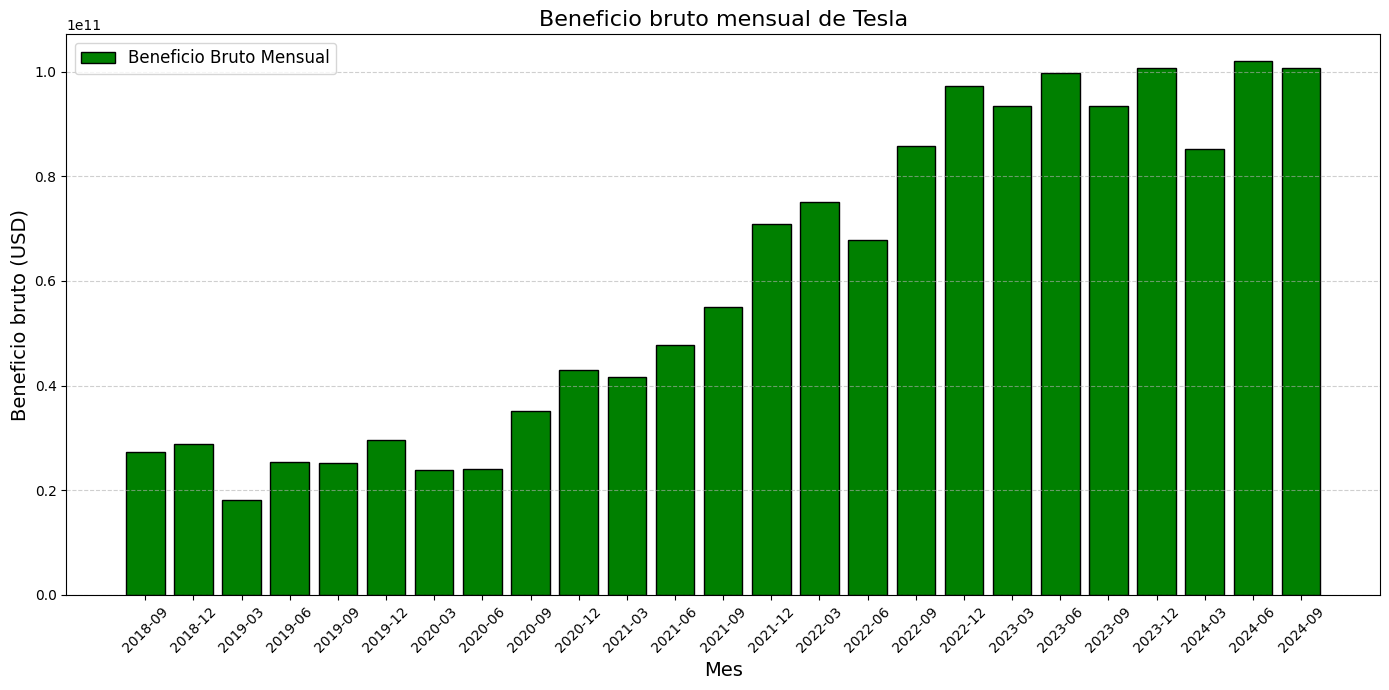

In [24]:
# Conectar a SQLite y cargar los datos en un DataFrame
connection = sqlite3.connect("Tesla.db")
query = "SELECT * FROM revenue"
tesla_revenue = pd.read_sql_query(query, connection)

# Convertir la columna Date a tipo datetime y ordenarla
tesla_revenue["Date"] = pd.to_datetime(tesla_revenue["Date"], format="%B %d, %Y", errors="coerce")
tesla_revenue = tesla_revenue.dropna(subset=["Date"])
tesla_revenue = tesla_revenue.sort_values(by="Date")

# Calcular los ingresos mensuales
tesla_revenue["Year-Month"] = tesla_revenue["Date"].dt.to_period("M")  # Crear columna "Año-Mes"
monthly_revenue = tesla_revenue.groupby("Year-Month")["Revenue"].sum().reset_index()  # Sumar ingresos por mes
monthly_revenue["Year-Month"] = monthly_revenue["Year-Month"].astype(str)  # Convertir Period a str para graficar

# Crear el gráfico del beneficio bruto mensual
plt.figure(figsize=(14, 7))
plt.bar(
    monthly_revenue["Year-Month"],
    monthly_revenue["Revenue"],
    color='green',  # Usar un color diferente (coral)
    edgecolor='black',
    label="Beneficio Bruto Mensual"
)

# Mejorar la visualización
plt.title("Beneficio bruto mensual de Tesla", fontsize=16)
plt.xlabel("Mes", fontsize=14)
plt.ylabel("Beneficio bruto (USD)", fontsize=14)
plt.xticks(fontsize=10, rotation=45)  # Rotar etiquetas de los meses
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

# Ajustar el diseño y mostrar el gráfico
plt.tight_layout()
plt.show()

# Cerrar la conexión a la base de datos
connection.close()

### **BENEFICIO MENSUAL DE TESLA** (2019-2024)

**Tendencia General:** 

- *Crecimiento sostenido:* El gráfico muestra una clara tendencia alcista en el beneficio bruto mensual de Tesla desde 2019 hasta 2024. Esto indica un crecimiento continuo y sólido de la empresa a lo largo de este período.


- *Aceleración en los últimos años:* Si bien el crecimiento es evidente desde el inicio, se observa una aceleración significativa en los últimos años, con picos cada vez más altos. Esto sugiere que Tesla ha logrado optimizar sus operaciones y capitalizar las oportunidades de mercado de manera más eficiente.


 <br/> 
 
## **VISUALIZACIÓN DEL BENEFICIO BRUTO ANUAL**

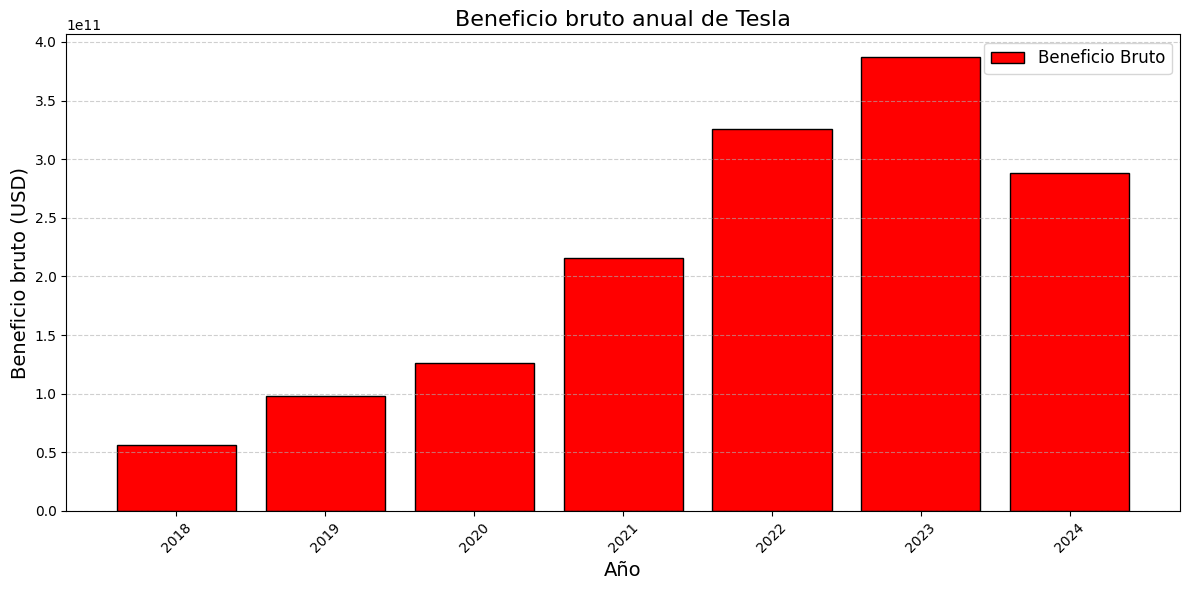

In [26]:

# Conectar a SQLite y cargar los datos en un DataFrame
connection = sqlite3.connect("Tesla.db")
query = "SELECT * FROM revenue"
tesla_revenue = pd.read_sql_query(query, connection)

# Convertir la columna Date a tipo datetime y ordenarla
tesla_revenue["Date"] = pd.to_datetime(tesla_revenue["Date"], format="%B %d, %Y", errors="coerce")
tesla_revenue = tesla_revenue.dropna(subset=["Date"])
tesla_revenue = tesla_revenue.sort_values(by="Date")

# Calcular los ingresos anuales (sumando trimestrales)
tesla_revenue["Year"] = tesla_revenue["Date"].dt.year  # Extraer el año
annual_revenue = tesla_revenue.groupby("Year")["Revenue"].sum().reset_index()  # Agrupar por año y sumar

# Crear el gráfico del beneficio bruto anual
plt.figure(figsize=(12, 6))
plt.bar(annual_revenue["Year"], annual_revenue["Revenue"], color='red', edgecolor='black', label="Beneficio Bruto")

# Mejorar la visualización
plt.title("Beneficio bruto anual de Tesla", fontsize=16)
plt.xlabel("Año", fontsize=14)
plt.ylabel("Beneficio bruto (USD)", fontsize=14)
plt.xticks(annual_revenue["Year"], fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(fontsize=12)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# Cerrar la conexión a la base de datos
connection.close()


### **BENEFICIO BRUTO ANUAL DE TESLA**

- Los resultados financieros de Tesla reflejan una tendencia de expansión y fortalecimiento sostenido.
- La tasa de crecimiento del beneficio bruto de Tesla se ha intensificado notablemente en los últimos años.



 <br/> 

# **ANÁLISIS DE LA EVOLUCIÓN DE LOS BENEFICIOS DE TESLA**


### **EVENTOS CLAVE QUE HAN INFLUIDO EN EL BENEFICIO BRUTO DE TESLA**


A continuación, se presentan algunos de los eventos más destacados que han tenido un impacto significativo en el beneficio bruto de Tesla:

**LANZAMIENTO DE NUEVOS MODELOS**:

- **Model 3 y Model Y:** El lanzamiento de estos modelos más asequibles y con mayor volumen de producción ha sido un factor clave en el crecimiento de las ventas y del beneficio bruto de Tesla. Estos vehículos han permitido a la compañía alcanzar un público más amplio y aumentar su cuota de mercado.
Cybertruck y otros modelos: El anuncio y posterior lanzamiento de nuevos modelos, como el Cybertruck, ha generado gran expectativa y ha contribuido a mantener el interés de los inversores y los consumidores.
Expansión Geográfica:

- **Nuevas fábricas:** La construcción de nuevas fábricas en China, Alemania y Texas ha permitido a Tesla aumentar su capacidad de producción y reducir los costos de fabricación.
Penetración en nuevos mercados: La expansión a mercados emergentes ha abierto nuevas oportunidades de crecimiento y ha diversificado las fuentes de ingresos de la compañía.


**PANDEMIA COVID-19:**

- **Disrupción en la cadena de suministro:** La pandemia ha generado interrupciones en la cadena de suministro global, lo que ha afectado la producción y las entregas de vehículos.

- **Aumento de la demanda de vehículos eléctricos:** Irónicamente, la pandemia también ha impulsado la demanda de vehículos eléctricos, ya que los consumidores han buscado alternativas más seguras y sostenibles de transporte.

**CAMBIOS GUBERNAMENTALES:**

- **Incentivos fiscales:** Los incentivos fiscales y las subvenciones gubernamentales para la compra de vehículos eléctricos han sido fundamentales para estimular la demanda y reducir los costos para los consumidores.
- **Regulaciones ambientales:** Las regulaciones más estrictas sobre las emisiones de gases de efecto invernadero han impulsado la transición hacia vehículos eléctricos y han beneficiado a Tesla.


**INNOVACIONES TECNOLÓGICAS:**

- **Batería 4680:** El desarrollo de la batería 4680 promete aumentar la autonomía y reducir los costos de producción de los vehículos eléctricos de Tesla.
Autopilot y conducción autónoma: La inversión en tecnología de conducción autónoma ha posicionado a Tesla como líder en este campo y ha generado gran expectativa entre los inversores.

## **CONCLUSIONES:** 

La trayectoria de crecimiento de Tesla ha sido impulsada por una combinación de factores internos y externos, destacando la importancia de la innovación, la ejecución y las condiciones de mercado favorables.

Si bien los resultados han sido positivos, es fundamental reconocer que el futuro presenta incertidumbres. La capacidad de Tesla para mantener este impulso dependerá de su habilidad para adaptarse a un entorno empresarial en constante evolución y de su capacidad para seguir innovando y satisfaciendo las necesidades cambiantes de los consumidores.